In [3]:

# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# Configuración de estilos
sns.set(style='whitegrid')
%matplotlib inline

In [4]:
# Cargar los datos
orders = pd.read_csv('../data/orders.csv')
order_products_prior = pd.read_csv('../data/order_products__prior.csv')
products = pd.read_csv('../data/products.csv')
aisles = pd.read_csv('../data/aisles.csv')
departments = pd.read_csv('../data/departments.csv')

Feature engineering
-----------

In [5]:
# Calcular fecha de la última compra en el dataset
max_order_number = orders['order_number'].max()

# Recency: Días desde el último pedido de cada usuario
user_last_order = orders.groupby('user_id')['days_since_prior_order'].sum().reset_index()
user_last_order.columns = ['user_id', 'recency']

# Frequency: Número de pedidos por usuario
user_freq = orders.groupby('user_id')['order_number'].max().reset_index()
user_freq.columns = ['user_id', 'frequency']

# Monetary: Número total de productos comprados por usuario (puede ser aproximación de "valor")
user_monetary = order_products_prior.merge(orders[['order_id', 'user_id']], on='order_id')
user_monetary = user_monetary.groupby('user_id').size().reset_index(name='monetary')

# Unión de las métricas
rfm = user_last_order.merge(user_freq, on='user_id').merge(user_monetary, on='user_id')

Creación de datos demográficos simulados
-----------

In [6]:
def perfilar_cliente(row):
    freq = row['frequency']
    mon = row['monetary']
    rec = row['recency']

    if freq > 25 and mon > 120:
        return 'familia_suburbana'
    elif freq > 15 and mon > 80:
        return 'profesional_activo'
    elif freq < 5 and mon < 50 and rec > 60:
        return 'comprador_esp sporádico'
    elif freq < 8 and mon < 60 and row['recency'] < 30:
        return 'joven_urbano'
    elif freq < 10 and mon > 100:
        return 'senior_estable'
    else:
        return 'profesional_activo'  # default

def simular_demografia_perfilada(row):
    perfil = perfilar_cliente(row)
    edad = renta = hogar = sexo = estado = zona = None

    if perfil == 'joven_urbano':
        edad = np.random.randint(18, 30)
        renta = np.random.normal(1400, 200)
        hogar = np.random.choice([1, 2], p=[0.8, 0.2])
        estado = 'soltero/a'
        zona = 'urbana'

    elif perfil == 'profesional_activo':
        edad = np.random.randint(30, 45)
        renta = np.random.normal(2500, 500)
        hogar = np.random.choice([1, 2, 3], p=[0.4, 0.4, 0.2])
        estado = np.random.choice(['soltero/a', 'casado/a'], p=[0.4, 0.6])
        zona = np.random.choice(['urbana', 'suburbana'], p=[0.6, 0.4])

    elif perfil == 'familia_suburbana':
        edad = np.random.randint(35, 55)
        renta = np.random.normal(3200, 600)
        hogar = np.random.choice([3, 4, 5], p=[0.3, 0.4, 0.3])
        estado = 'casado/a'
        zona = 'suburbana'

    elif perfil == 'senior_estable':
        edad = np.random.randint(55, 75)
        renta = np.random.normal(2000, 300)
        hogar = np.random.choice([1, 2], p=[0.5, 0.5])
        estado = np.random.choice(['viudo/a', 'casado/a', 'divorciado/a'], p=[0.4, 0.4, 0.2])
        zona = np.random.choice(['rural', 'suburbana'], p=[0.5, 0.5])

    elif perfil == 'comprador_esp sporádico':
        edad = np.random.choice([
            np.random.randint(18, 25),
            np.random.randint(60, 80)
        ])
        renta = np.random.normal(1200, 200)
        hogar = 1
        estado = 'soltero/a' if edad < 30 else 'viudo/a'
        zona = np.random.choice(['urbana', 'rural', 'suburbana'])

    sexo = np.random.choice(['hombre', 'mujer'], p=[0.48, 0.52])

    return pd.Series({
        'perfil_cliente': perfil,
        'edad': int(edad),
        'renta_mensual': int(abs(renta)),
        'sexo': sexo,
        'estado_civil': estado,
        'tamaño_hogar': hogar,
        'zona_residencial': zona
    })


Merge para crear mi dataframe de trabajo
-------

In [7]:
user_info_rich = rfm.apply(simular_demografia_perfilada, axis=1)
user_info_rich['user_id'] = rfm['user_id']
# Realizar la unión con un 'left join' para conservar todas las filas de user_info_rich
user_info_rich = pd.merge(user_info_rich, rfm[['user_id', 'recency', 'frequency', 'monetary']], on='user_id', how='left')




In [8]:
user_info_rich

,perfil_cliente,edad,renta_mensual,sexo,estado_civil,tamaño_hogar,zona_residencial,user_id,recency,frequency,monetary
0,profesional_activo,44,2465,mujer,soltero/a,1,suburbana,1,190.0,11,59
1,profesional_activo,40,2363,mujer,casado/a,2,urbana,2,228.0,15,195
2,profesional_activo,30,2018,mujer,casado/a,2,urbana,3,144.0,13,88
3,profesional_activo,38,3268,hombre,casado/a,3,suburbana,4,85.0,6,18
4,profesional_activo,44,2655,mujer,soltero/a,1,suburbana,5,46.0,5,37
...,...,...,...,...,...,...,...,...,...,...,...
206204,profesional_activo,43,2368,mujer,casado/a,2,urbana,206205,50.0,4,32
206205,familia_suburbana,50,3168,mujer,casado/a,5,suburbana,206206,249.0,68,285
206206,profesional_activo,32,2265,hombre,soltero/a,3,urbana,206207,229.0,17,223
206207,familia_suburbana,48,2785,hombre,casado/a,3,suburbana,206208,361.0,50,677


In [9]:
user_info_rich['edad'].value_counts().sort_index()


edad
18    1254
19    1139
20    1126
21    1203
22    1226
      ... 
75     294
76     273
77     308
78     283
79     286
Name: count, Length: 62, dtype: int64

Mini EDA para ver si hay correlación con los datos simulados
---------------

In [10]:
import numpy as np

user_info_rich_numeric = user_info_rich.select_dtypes(include=np.number)
user_info_rich_numeric = user_info_rich_numeric.drop(columns='user_id', errors='ignore')


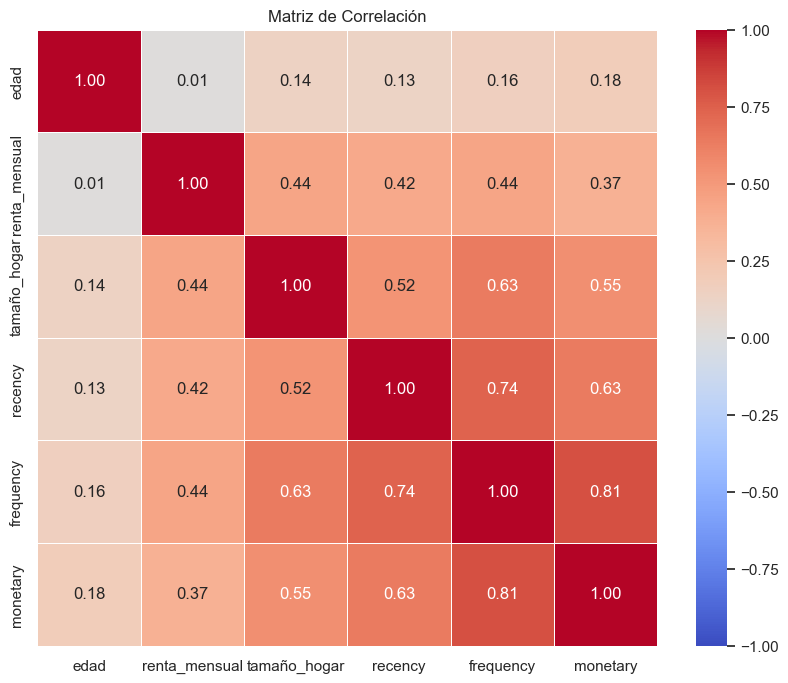

In [11]:

corr_matrix = user_info_rich_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()



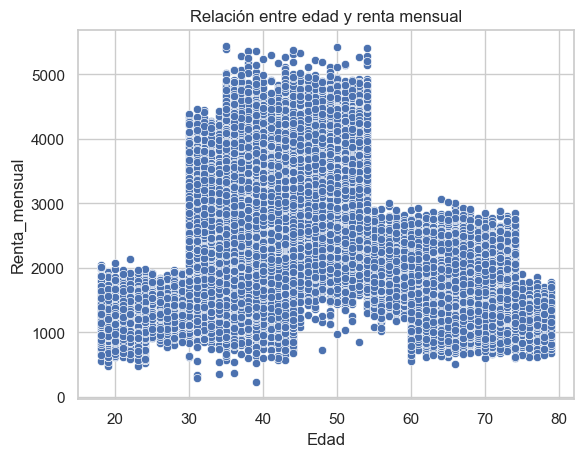

<Axes: xlabel='edad', ylabel='renta_mensual'>

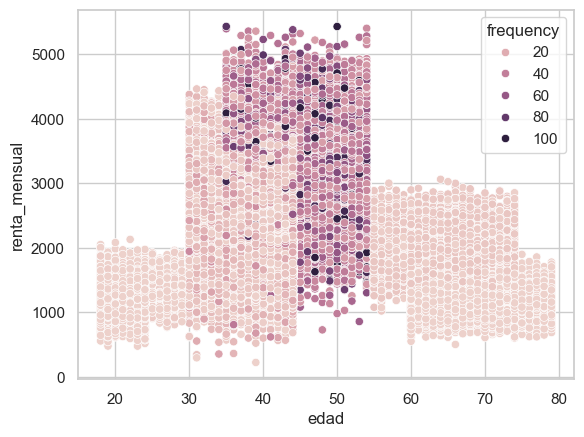

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que 'user_info_rich' es tu DataFrame
sns.scatterplot(data=user_info_rich_numeric, x='edad', y='renta_mensual')

# Personalizar el gráfico
plt.title('Relación entre edad y renta mensual')
plt.xlabel('Edad')
plt.ylabel('Renta_mensual')
plt.show()
sns.scatterplot(data=user_info_rich_numeric, x='edad', y='renta_mensual', hue='frequency')



Hago un Get dummies con los datos categóricos para poder trabajar con ellos
---------------------

In [13]:
import pandas as pd

# Aplicar get_dummies a las columnas categóricas
user_info_rich_dummies = pd.get_dummies(user_info_rich, columns=["sexo", "estado_civil", "zona_residencial"])


In [14]:
user_info_rich_dummies = pd.get_dummies(user_info_rich, columns=["sexo", "estado_civil", "zona_residencial"], drop_first=True)
user_info_rich_dummies = pd.get_dummies(user_info_rich, columns=["sexo", "estado_civil", "zona_residencial"], prefix=['gen', 'est_civ', "zona"])
user_info_rich_dummies

,perfil_cliente,edad,renta_mensual,tamaño_hogar,user_id,recency,frequency,monetary,gen_hombre,gen_mujer,est_civ_casado/a,est_civ_divorciado/a,est_civ_soltero/a,est_civ_viudo/a,zona_rural,zona_suburbana,zona_urbana
0,profesional_activo,44,2465,1,1,190.0,11,59,False,True,False,False,True,False,False,True,False
1,profesional_activo,40,2363,2,2,228.0,15,195,False,True,True,False,False,False,False,False,True
2,profesional_activo,30,2018,2,3,144.0,13,88,False,True,True,False,False,False,False,False,True
3,profesional_activo,38,3268,3,4,85.0,6,18,True,False,True,False,False,False,False,True,False
4,profesional_activo,44,2655,1,5,46.0,5,37,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,profesional_activo,43,2368,2,206205,50.0,4,32,False,True,True,False,False,False,False,False,True
206205,familia_suburbana,50,3168,5,206206,249.0,68,285,False,True,True,False,False,False,False,True,False
206206,profesional_activo,32,2265,3,206207,229.0,17,223,True,False,False,False,True,False,False,False,True
206207,familia_suburbana,48,2785,3,206208,361.0,50,677,True,False,True,False,False,False,False,True,False


In [15]:
user_info_rich_dummies.shape

(206209, 17)

In [16]:
# Eliminar las columnas 'perfil_cliente' y 'user_id'
user_info_rich_dummies = user_info_rich_dummies.drop(columns=['perfil_cliente', 'user_id'], errors='ignore')


In [17]:
#user_info_rich_dummies.info()


Escalado de los datos
----------

In [18]:
bool_cols = user_info_rich_dummies.select_dtypes(include='bool').columns
user_info_rich_dummies[bool_cols] = user_info_rich_dummies[bool_cols].astype(int)


In [19]:
#from scipy.sparse import csr_matrix
#comprimido= csr_matrix(user_info_rich_dummies.values)
#comprimido_dense = comprimido.toarray()

In [20]:
#comprimido_dense

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
scaled_data = scaler.fit_transform(user_info_rich_dummies)


# scaled_data = scaler.fit_transform(comprimido_dense)


In [22]:
scaled_data

array([[4.50615219, 3.63193609, 0.87680846, ..., 0.        , 2.00008446,
        0.        ],
       [4.09650199, 3.48164908, 1.75361691, ..., 0.        , 0.        ,
        2.00469391],
       [3.07237649, 2.97332537, 1.75361691, ..., 0.        , 0.        ,
        2.00469391],
       ...,
       [3.27720159, 3.33725568, 2.63042537, ..., 0.        , 0.        ,
        2.00469391],
       [4.91580239, 4.10342475, 2.63042537, ..., 0.        , 2.00008446,
        0.        ],
       [3.68685179, 4.36716372, 1.75361691, ..., 0.        , 0.        ,
        2.00469391]])

Calculo la inercia y el silhouette para ver cuántos clusters son los adecuados
---------------------------------

Initialization complete
Iteration 0, inertia 11729953.374121526.
Iteration 1, inertia 3093134.9999999804.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4546135.627364928.
Iteration 1, inertia 2768512.7586694444.
Iteration 2, inertia 2695134.060509271.
Iteration 3, inertia 2679141.548857988.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 3406915.642039231.
Iteration 1, inertia 2173585.929575383.
Iteration 2, inertia 2109494.4328932846.
Iteration 3, inertia 2065444.29122241.
Iteration 4, inertia 2064219.6847756028.
Iteration 5, inertia 2060163.9979772773.
Iteration 6, inertia 2055071.350967836.
Converged at iteration 6: center shift 9.040530337641922e-06 within tolerance 0.00010000000000003326.
Initialization complete
Iteration 0, inertia 2945771.474859808.
Iteration 1, inertia 1974960.8251894626.
Iteration 2, inertia 1816973.0818442823.
Iteration 3, inertia 1726215.0709151179.
Iteration 4, inertia 1

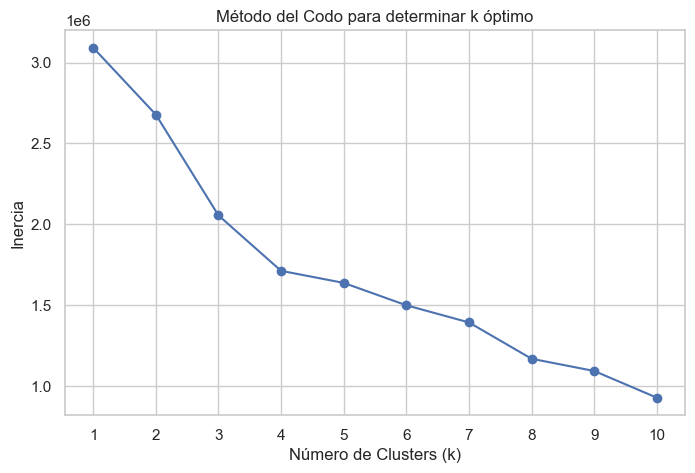

In [23]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#Probar diferentes valores de k
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42,  verbose=3)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar k óptimo')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [25]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import resample

Entrenando MiniBatchKMeans con k=2...
Init 1/1 with method k-means++
Inertia for init 1/1: 119405.86397365775
Minibatch step 1/10068: mean batch inertia: 19.47418995077742
Minibatch step 2/10068: mean batch inertia: 11.459688872069547, ewa inertia: 11.459688872069547
Minibatch step 3/10068: mean batch inertia: 11.914788302063952, ewa inertia: 11.468728624095428
Minibatch step 4/10068: mean batch inertia: 11.89091334193016, ewa inertia: 11.477114583089906
Minibatch step 5/10068: mean batch inertia: 11.829140904668545, ewa inertia: 11.484106968586177
Minibatch step 6/10068: mean batch inertia: 12.835947688365787, ewa inertia: 11.510958913633543
Minibatch step 7/10068: mean batch inertia: 11.931403167359187, ewa inertia: 11.51931030136091
Minibatch step 8/10068: mean batch inertia: 12.038290025086528, ewa inertia: 11.529618923388846
Minibatch step 9/10068: mean batch inertia: 11.908475302538605, ewa inertia: 11.537144240924356
Minibatch step 10/10068: mean batch inertia: 11.32897954575796

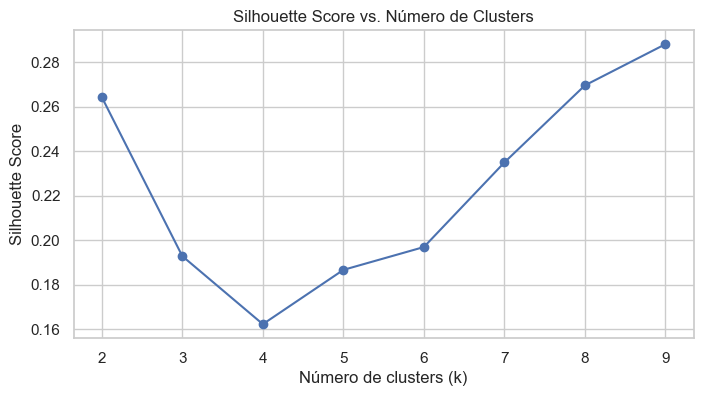

In [26]:
'''
Aquí estoy utilizando solamente parte de los datos porque con la totalidad de los datos y utilizando KMeans no acababa de darme resultados.
Por ello, paso a utilizar MiniBatchKMeans y defino un batch_size de 2048
'''
X = scaled_data  # ya densificado antes
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    print(f"Entrenando MiniBatchKMeans con k={k}...")
    
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, verbose=3, batch_size=2048)
    labels = kmeans.fit_predict(X)

    # 🔥 Muestra representativa para calcular el score más rápido
    X_sample, labels_sample = resample(X, labels, n_samples=10000, random_state=42)
    score = silhouette_score(X_sample, labels_sample)
    
    silhouette_scores.append(score)
    print(f"Silhouette Score para k={k}: {score:.4f}\n")

# Visualizar resultados
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Número de Clusters')
plt.grid(True)
plt.show()


¿Qué significa ese score?
El Silhouette Score va de -1 a 1:

🔴 < 0.2 → clusters solapados o difusos, mal definidos.

🟡 0.2 - 0.3 → aceptable, hay algo de estructura, pero no súper clara.

🟢 > 0.3 → buena separación, clusters útiles.

Tú estás en ~0.30 en k=9, lo que está bastante bien teniendo en cuenta que estás usando datos simulados, dummies, y muchos usuarios.

Voy a probar con 3 clusters
--------------

In [27]:
# Entrenamos con k=3
kmeans_3 = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=2048)
labels_3 = kmeans_3.fit_predict(X)

# Añadir los clusters al DataFrame original
user_info_rich_dummies['cluster'] = labels_3


In [28]:
user_info_rich_dummies

,edad,renta_mensual,tamaño_hogar,recency,frequency,monetary,gen_hombre,gen_mujer,est_civ_casado/a,est_civ_divorciado/a,est_civ_soltero/a,est_civ_viudo/a,zona_rural,zona_suburbana,zona_urbana,cluster
0,44,2465,1,190.0,11,59,0,1,0,0,1,0,0,1,0,1
1,40,2363,2,228.0,15,195,0,1,1,0,0,0,0,0,1,1
2,30,2018,2,144.0,13,88,0,1,1,0,0,0,0,0,1,1
3,38,3268,3,85.0,6,18,1,0,1,0,0,0,0,1,0,0
4,44,2655,1,46.0,5,37,0,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,43,2368,2,50.0,4,32,0,1,1,0,0,0,0,0,1,1
206205,50,3168,5,249.0,68,285,0,1,1,0,0,0,0,1,0,2
206206,32,2265,3,229.0,17,223,1,0,0,0,1,0,0,0,1,1
206207,48,2785,3,361.0,50,677,1,0,1,0,0,0,0,1,0,2


In [29]:
# Agrupar por cluster y ver medias de características
user_info_rich_dummies.groupby('cluster').mean(numeric_only=True).round(2)


,edad,renta_mensual,tamaño_hogar,recency,frequency,monetary,gen_hombre,gen_mujer,est_civ_casado/a,est_civ_divorciado/a,est_civ_soltero/a,est_civ_viudo/a,zona_rural,zona_suburbana,zona_urbana
cluster,,,,,,,,,,,,,,,
0,41.42,2330.40,1.70,142.15,10.18,90.88,0.72,0.28,0.72,0.02,0.15,0.1,0.08,0.61,0.31
1,35.58,2380.13,1.73,143.09,10.53,88.48,0.24,0.76,0.33,0.00,0.67,0.0,0.01,0.16,0.83
2,44.24,3191.63,3.95,314.74,45.37,469.01,0.47,0.53,1.00,0.00,0.00,0.0,0.00,1.00,0.00


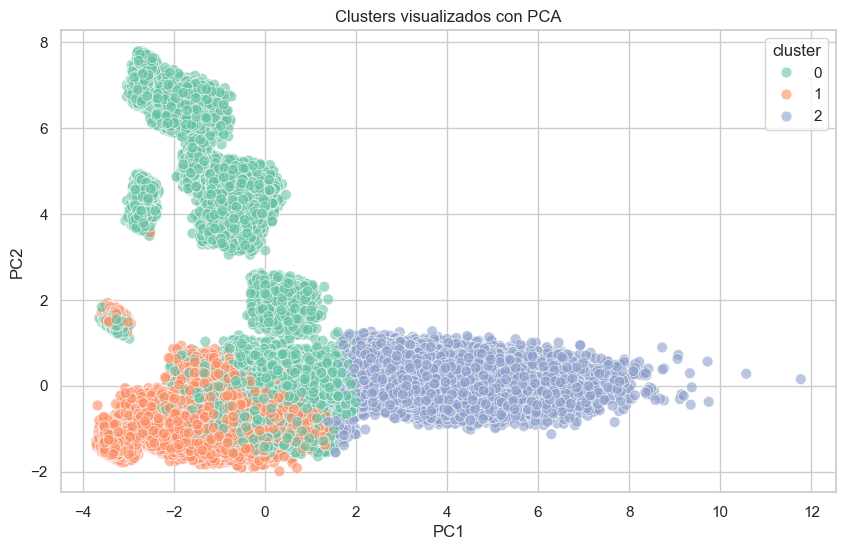

In [30]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Aplicamos PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Montamos un DataFrame para graficar
df_viz = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'cluster': labels_3
})

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_viz, x='PC1', y='PC2', hue='cluster', palette='Set2', alpha=0.6, s=60)
plt.title('Clusters visualizados con PCA')
plt.show()


Voy a probar con 4 clusters
---------

In [31]:
# Entrenamos con k=4
kmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=2048)
labels_4 = kmeans_4.fit_predict(X)

# Añadir los clusters al DataFrame original
user_info_rich_dummies['cluster'] = labels_4


In [32]:
user_info_rich_dummies

,edad,renta_mensual,tamaño_hogar,recency,frequency,monetary,gen_hombre,gen_mujer,est_civ_casado/a,est_civ_divorciado/a,est_civ_soltero/a,est_civ_viudo/a,zona_rural,zona_suburbana,zona_urbana,cluster
0,44,2465,1,190.0,11,59,0,1,0,0,1,0,0,1,0,1
1,40,2363,2,228.0,15,195,0,1,1,0,0,0,0,0,1,1
2,30,2018,2,144.0,13,88,0,1,1,0,0,0,0,0,1,1
3,38,3268,3,85.0,6,18,1,0,1,0,0,0,0,1,0,0
4,44,2655,1,46.0,5,37,0,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,43,2368,2,50.0,4,32,0,1,1,0,0,0,0,0,1,1
206205,50,3168,5,249.0,68,285,0,1,1,0,0,0,0,1,0,3
206206,32,2265,3,229.0,17,223,1,0,0,0,1,0,0,0,1,1
206207,48,2785,3,361.0,50,677,1,0,1,0,0,0,0,1,0,2


In [33]:
# Agrupar por cluster y ver medias de características
user_info_rich_dummies.groupby('cluster').mean(numeric_only=True).round(2)

,edad,renta_mensual,tamaño_hogar,recency,frequency,monetary,gen_hombre,gen_mujer,est_civ_casado/a,est_civ_divorciado/a,est_civ_soltero/a,est_civ_viudo/a,zona_rural,zona_suburbana,zona_urbana
cluster,,,,,,,,,,,,,,,
0,41.56,2316.78,1.68,138.10,9.83,87.67,0.73,0.27,0.72,0.02,0.16,0.11,0.08,0.59,0.32
1,35.57,2379.53,1.73,142.88,10.52,88.28,0.24,0.76,0.33,0.00,0.67,0.00,0.01,0.16,0.83
2,44.47,3203.34,4.03,336.61,69.05,844.10,0.47,0.53,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3,43.52,3142.51,3.77,302.92,35.87,329.81,0.45,0.55,0.99,0.00,0.01,0.00,0.00,1.00,0.00


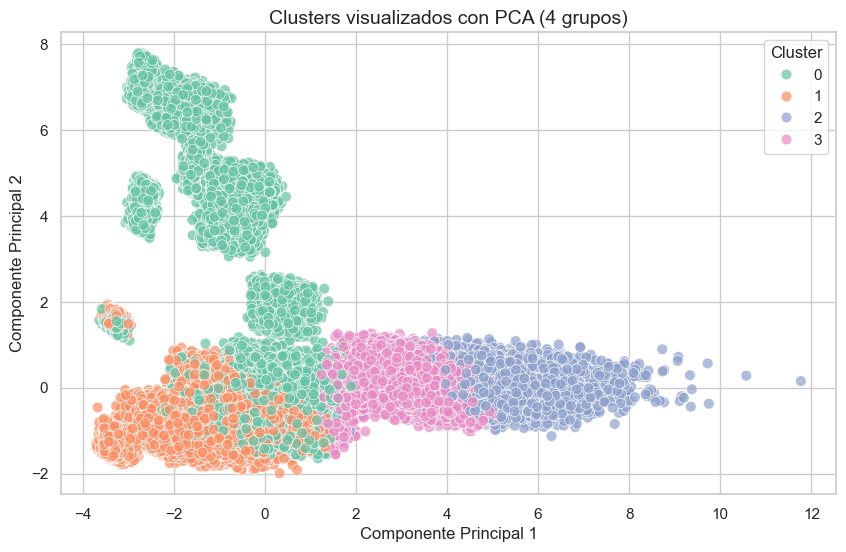

In [34]:

# Aplicamos PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Creamos DataFrame para graficar
df_viz = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'cluster': labels_4  # aquí van tus etiquetas
})

# Plot bonito con Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_viz,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='Set2',
    alpha=0.7,
    s=60
)
plt.title('Clusters visualizados con PCA (4 grupos)', fontsize=14)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


Vamos a probar con 2 clusters
--------

In [35]:
# Entrenamos con k=2
kmeans_2 = MiniBatchKMeans(n_clusters=2, random_state=42, batch_size=2048)
labels_2 = kmeans_2.fit_predict(X)

# Añadir los clusters al DataFrame original
user_info_rich_dummies['cluster'] = labels_2

In [36]:
user_info_rich_dummies

,edad,renta_mensual,tamaño_hogar,recency,frequency,monetary,gen_hombre,gen_mujer,est_civ_casado/a,est_civ_divorciado/a,est_civ_soltero/a,est_civ_viudo/a,zona_rural,zona_suburbana,zona_urbana,cluster
0,44,2465,1,190.0,11,59,0,1,0,0,1,0,0,1,0,0
1,40,2363,2,228.0,15,195,0,1,1,0,0,0,0,0,1,0
2,30,2018,2,144.0,13,88,0,1,1,0,0,0,0,0,1,0
3,38,3268,3,85.0,6,18,1,0,1,0,0,0,0,1,0,0
4,44,2655,1,46.0,5,37,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,43,2368,2,50.0,4,32,0,1,1,0,0,0,0,0,1,0
206205,50,3168,5,249.0,68,285,0,1,1,0,0,0,0,1,0,1
206206,32,2265,3,229.0,17,223,1,0,0,0,1,0,0,0,1,0
206207,48,2785,3,361.0,50,677,1,0,1,0,0,0,0,1,0,1


In [37]:
# Agrupar por cluster y ver medias de características
user_info_rich_dummies.groupby('cluster').mean(numeric_only=True).round(2)

,edad,renta_mensual,tamaño_hogar,recency,frequency,monetary,gen_hombre,gen_mujer,est_civ_casado/a,est_civ_divorciado/a,est_civ_soltero/a,est_civ_viudo/a,zona_rural,zona_suburbana,zona_urbana
cluster,,,,,,,,,,,,,,,
0,38.56,2351.17,1.71,141.26,10.22,88.31,0.48,0.52,0.53,0.01,0.41,0.05,0.05,0.38,0.57
1,43.97,3168.17,3.88,312.58,44.29,457.37,0.48,0.52,1.00,0.00,0.00,0.00,0.00,1.00,0.00


Vamos a probar con 8 clusters
--------

In [ ]:
# Entrenamos con k=8
kmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=42, batch_size=2048)
labels_8 = kmeans_8.fit_predict(X)

# Añadir los clusters al DataFrame original
user_info_rich_dummies['cluster'] = labels_8



In [ ]:
# Entrenamos con k=8 y Kmeans con todo el dataset o no 
X_df=pd.DataFrame(X, columns=user_info_rich_dummies.drop("cluster",axis=1).columns)
X_sample_2= X_df.sample(frac=0.1)
kmeans_8 = KMeans(n_clusters=8, random_state=42, n_init= 10)
labels_8 = kmeans_8.fit_predict(X)

# Añadir los clusters al DataFrame original
user_info_rich_dummies['cluster'] = labels_8

In [44]:
user_info_rich_dummies

,edad,renta_mensual,tamaño_hogar,recency,frequency,monetary,gen_hombre,gen_mujer,est_civ_casado/a,est_civ_divorciado/a,est_civ_soltero/a,est_civ_viudo/a,zona_rural,zona_suburbana,zona_urbana,cluster
0,44,2465,1,190.0,11,59,0,1,0,0,1,0,0,1,0,1
1,40,2363,2,228.0,15,195,0,1,1,0,0,0,0,0,1,3
2,30,2018,2,144.0,13,88,0,1,1,0,0,0,0,0,1,3
3,38,3268,3,85.0,6,18,1,0,1,0,0,0,0,1,0,0
4,44,2655,1,46.0,5,37,0,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,43,2368,2,50.0,4,32,0,1,1,0,0,0,0,0,1,3
206205,50,3168,5,249.0,68,285,0,1,1,0,0,0,0,1,0,6
206206,32,2265,3,229.0,17,223,1,0,0,0,1,0,0,0,1,7
206207,48,2785,3,361.0,50,677,1,0,1,0,0,0,0,1,0,2


In [49]:
# Agrupar por cluster y ver medias de características
user_info_rich_dummies.groupby('cluster').mean(numeric_only=True).round(2)

,edad,renta_mensual,tamaño_hogar,recency,frequency,monetary,gen_hombre,gen_mujer,est_civ_casado/a,est_civ_divorciado/a,est_civ_soltero/a,est_civ_viudo/a,zona_rural,zona_suburbana,zona_urbana
cluster,,,,,,,,,,,,,,,
0,36.95,2495.92,1.80,153.75,11.30,96.34,1.00,0.00,1.00,0.0,0.0,0.00,0.00,0.00,1.00
1,38.36,2473.98,1.81,152.05,11.34,97.53,0.48,0.52,1.00,0.0,0.0,0.00,0.00,1.00,0.00
2,44.46,3209.30,4.00,316.84,46.22,478.05,0.48,0.52,1.00,0.0,0.0,0.00,0.00,1.00,0.00
3,67.22,1573.54,1.23,97.64,5.73,74.87,0.47,0.53,0.16,0.0,0.0,0.84,0.49,0.33,0.18
4,34.84,2316.75,1.70,139.74,10.24,85.56,1.00,0.00,0.00,0.0,1.0,0.00,0.03,0.37,0.60
5,34.82,2322.41,1.70,138.91,10.21,85.64,0.00,1.00,0.00,0.0,1.0,0.00,0.03,0.37,0.60
6,64.59,2007.70,1.49,122.34,7.68,133.75,0.47,0.53,0.00,1.0,0.0,0.00,0.49,0.51,0.00
7,37.03,2497.13,1.80,153.10,11.21,95.36,0.00,1.00,1.00,0.0,0.0,0.00,0.00,0.00,1.00


In [43]:
user_info_rich_dummies.groupby('cluster').count()

,edad,renta_mensual,tamaño_hogar,recency,frequency,monetary,gen_hombre,gen_mujer,est_civ_casado/a,est_civ_divorciado/a,est_civ_soltero/a,est_civ_viudo/a,zona_rural,zona_suburbana,zona_urbana
cluster,,,,,,,,,,,,,,,
0,29113,29113,29113,29113,29113,29113,29113,29113,29113,29113,29113,29113,29113,29113,29113
1,30661,30661,30661,30661,30661,30661,30661,30661,30661,30661,30661,30661,30661,30661,30661
2,8928,8928,8928,8928,8928,8928,8928,8928,8928,8928,8928,8928,8928,8928,8928
3,46122,46122,46122,46122,46122,46122,46122,46122,46122,46122,46122,46122,46122,46122,46122
4,12261,12261,12261,12261,12261,12261,12261,12261,12261,12261,12261,12261,12261,12261,12261
5,25303,25303,25303,25303,25303,25303,25303,25303,25303,25303,25303,25303,25303,25303,25303
6,27308,27308,27308,27308,27308,27308,27308,27308,27308,27308,27308,27308,27308,27308,27308
7,26513,26513,26513,26513,26513,26513,26513,26513,26513,26513,26513,26513,26513,26513,26513


Vamos a probar con 9 clusters
--------

In [51]:
# Entrenamos con k=8
kmeans_9 = MiniBatchKMeans(n_clusters=9, random_state=42, batch_size=2048)
labels_9 = kmeans_9.fit_predict(X)

# Añadir los clusters al DataFrame original
user_info_rich_dummies['cluster'] = labels_9

In [52]:
user_info_rich_dummies


,edad,renta_mensual,tamaño_hogar,recency,frequency,monetary,gen_hombre,gen_mujer,est_civ_casado/a,est_civ_divorciado/a,est_civ_soltero/a,est_civ_viudo/a,zona_rural,zona_suburbana,zona_urbana,cluster
0,44,2465,1,190.0,11,59,0,1,0,0,1,0,0,1,0,1
1,40,2363,2,228.0,15,195,0,1,1,0,0,0,0,0,1,3
2,30,2018,2,144.0,13,88,0,1,1,0,0,0,0,0,1,3
3,38,3268,3,85.0,6,18,1,0,1,0,0,0,0,1,0,0
4,44,2655,1,46.0,5,37,0,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,43,2368,2,50.0,4,32,0,1,1,0,0,0,0,0,1,3
206205,50,3168,5,249.0,68,285,0,1,1,0,0,0,0,1,0,6
206206,32,2265,3,229.0,17,223,1,0,0,0,1,0,0,0,1,7
206207,48,2785,3,361.0,50,677,1,0,1,0,0,0,0,1,0,2


In [56]:
# Entrenamos con k=9
#X_df=pd.DataFrame(X, columns=user_info_rich_dummies.drop("cluster",axis=1).columns)
#X_sample_3= X_df.sample(frac=0.1)
kmeans_9 = KMeans(n_clusters=9, random_state=42, n_init= 10)
labels_9 = kmeans_9.fit_predict(X)

# Añadir los clusters al DataFrame original
user_info_rich_dummies['cluster'] = labels_9

In [57]:
# Agrupar por cluster y ver medias de características
user_info_rich_dummies.groupby('cluster').mean(numeric_only=True).round(2)

,edad,renta_mensual,tamaño_hogar,recency,frequency,monetary,gen_hombre,gen_mujer,est_civ_casado/a,est_civ_divorciado/a,est_civ_soltero/a,est_civ_viudo/a,zona_rural,zona_suburbana,zona_urbana
cluster,,,,,,,,,,,,,,,
0,36.95,2495.92,1.80,153.75,11.30,96.34,1.00,0.00,1.00,0.0,0.00,0.00,0.00,0.00,1.00
1,44.46,3209.35,4.00,316.85,46.22,478.07,0.48,0.52,1.00,0.0,0.00,0.00,0.00,1.00,0.00
2,37.03,2497.13,1.80,153.10,11.21,95.36,0.00,1.00,1.00,0.0,0.00,0.00,0.00,0.00,1.00
3,35.26,2350.37,1.72,141.60,10.42,87.44,1.00,0.00,0.00,0.0,1.00,0.00,0.00,0.38,0.62
4,53.74,1557.04,1.22,97.14,5.68,73.29,0.48,0.52,0.23,0.0,0.28,0.49,1.00,0.00,0.00
5,68.10,1455.71,1.16,91.05,5.16,57.98,0.47,0.53,0.00,0.0,0.00,1.00,0.00,0.65,0.35
6,38.37,2474.01,1.81,152.05,11.34,97.55,0.48,0.52,1.00,0.0,0.00,0.00,0.00,1.00,0.00
7,64.59,2007.70,1.49,122.34,7.68,133.75,0.47,0.53,0.00,1.0,0.00,0.00,0.49,0.51,0.00
8,35.23,2356.24,1.72,140.74,10.39,87.51,0.00,1.00,0.00,0.0,1.00,0.00,0.00,0.38,0.62


In [62]:
user_info_rich_dummies["cluster"].count()

206209

In [64]:
user_info_rich_dummies.groupby("cluster")["edad"].count()


cluster
0    25303
1    35253
2    27559
3    32261
4     7207
5     5446
6    37081
7     1608
8    34491
Name: edad, dtype: int64

Análisis de Segmentación de Clientes: El Modelo de 9 Clusters
---------
Hemos seleccionado el modelo de clustering con 9 segmentos por ofrecer perfiles de cliente distintivos y útiles para la estrategia de marketing en Instacart. A continuación, presentamos un análisis detallado de cada uno de estos 9 clusters, incluyendo sus métricas promedio clave, el número de usuarios que lo componen y las implicaciones estratégicas de su tamaño. Los clusters considerados más importantes por su potencial o necesidades específicas están resaltados visualmente en la tabla.